In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

## Load in data

In [2]:
# Read in energy generation data as dataframe
generation_df = pd.read_csv('Data/energy_generation_data.csv', index_col=0, parse_dates=True)

generation_df.head()

,coal,natural gas,nuclear,petroleum,other,solar,hydro,wind
date,,,,,,,,
2023-12-31,1870097,4270620,2245684,7293,221858,305983,632266,1074159
2023-12-30,1964710,4369981,2215492,7661,224151,322528,628762,1064144
2023-12-29,1948705,4482785,2228321,8311,216563,312185,718066,1109628
2023-12-28,1776641,4480968,2224448,9639,209483,309365,701614,1119395
2023-12-27,1679634,4397551,2215389,8236,218310,262265,723729,1093226


In [3]:
# Reorder to dates ascending
generation_df = generation_df.sort_index()

generation_df.head()

,coal,natural gas,nuclear,petroleum,other,solar,hydro,wind
date,,,,,,,,
2019-01-01,2596861,2799020,2476849,10747,179678,102279,804553,561924
2019-01-02,2815323,3652337,2487248,6718,197419,105653,905440,491233
2019-01-03,2702126,3595766,2485906,8444,198361,109039,869689,709083
2019-01-04,2664270,3543125,2469281,7251,193085,110691,849861,584117
2019-01-05,2482182,3043584,2442032,5209,185661,67261,824607,702299


In [4]:
# Create total column
generation_df['total_generated'] = generation_df.sum(axis=1)

# Isolate total column to use in univariate forecast
total_generated_df = generation_df[['total_generated']]

total_generated_df.head()

,total_generated
date,
2019-01-01,9531911
2019-01-02,10661371
2019-01-03,10678414
2019-01-04,10421681
2019-01-05,9752835


## Functions used in modeling

In [5]:
def split_time_dataset(df, test_size=0.2):
    '''
    Split a time-series dataframe with a datetime index into training
    and test sets.
    '''
    train_size = int(len(df) * (1 - test_size))
    
    train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]
    
    return train_data, test_data

In [6]:
def create_windows(data, window_size=10):
    '''
    Return data segmented into windows of a set size as a numpy array.
    '''
    X, y = [], []
    
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
        
    return np.array(X), np.array(y)

In [7]:
def scale_data(train_data, test_data):
    '''
    Fit an instance of MinMaxScaler using training data and then
    transforming the training and test sets.
    '''
    scaler = MinMaxScaler()
    
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)
    
    return scaler, train_data_scaled, test_data_scaled

In [8]:
def get_predictions(model, X_train, y_train, epochs=20):
    '''
    Fits built model on training data and generates the prediction values
    for both the training set and test set.
    '''
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    return train_pred, test_pred

In [9]:
def unscale_data(scaler, y, y_pred):
    '''
    Takes previously fitted scaler instance and inverse transforms
    predictions and original target values back to the original scale.
    '''
    y_unscaled = scaler.inverse_transform([y])
    y_pred_unscaled = scaler.inverse_transform(y_pred)
    
    return y_unscaled, y_pred_unscaled

In [10]:
def root_mean_squared_error(y, y_pred):
    '''
    Calculate the root mean squared error of the target value and model predictions.
    '''
    mse = mean_squared_error(y[0], y_pred)
    rmse = np.sqrt(mse)
    
    return rmse

In [11]:
def shift_predictions(train_pred, test_pred, df, window_size=10):
    '''
    Takes generated predictions and aligns them with the original
    x-axis to allow for plotting against original data.
    '''
    shifted_train_pred = np.empty((len(df), 1))
    shifted_train_pred[:] = np.nan
    shifted_train_pred[window_size:len(train_pred) + window_size, :] = train_pred
    
    shifted_test_pred = np.empty((len(df), 1))
    shifted_test_pred[:] = np.nan
    shifted_test_pred[len(train_pred) + (window_size * 2) + 1:len(df) - 1, :] = test_pred
    
    return shifted_train_pred, shifted_test_pred

In [12]:
def plot_predictions(df, shifted_train_pred, shifted_test_pred):
    '''
    Plots a line chart with both the original dataset and predictions
    generated from the models.
    '''
    plt.figure(figsize=(12, 8))
    plt.plot(df, label='Original Data')
    plt.plot(df.index, shifted_train_pred, label='Training Set Predictions')
    plt.plot(df.index, shifted_test_pred, label='Test Set Predictions')
    
    plt.title(f'Forecast for {df.columns[0]}')
    plt.ylabel('Total Energy (MegaWattHours)')
    plt.legend()
    plt.show()

## Data preparation

In [13]:
# Split total_generated_df into training and test sets
train_data, test_data = split_time_dataset(total_generated_df)

# Scale data
scaler, train_data_scaled, test_data_scaled = scale_data(train_data, test_data)

# Create windowed datasets
X_train, y_train = create_windows(train_data_scaled)
X_test, y_test = create_windows(test_data_scaled)

print(X_train.shape, X_train[:3], y_train[:3], X_test.shape, sep='\n')

(1449, 10)
[[0.20317011 0.38060215 0.38327951 0.34294815 0.23787607 0.20615883
  0.30500588 0.28446734 0.37684068 0.4728949 ]
 [0.38060215 0.38327951 0.34294815 0.23787607 0.20615883 0.30500588
  0.28446734 0.37684068 0.4728949  0.45130461]
 [0.38327951 0.34294815 0.23787607 0.20615883 0.30500588 0.28446734
  0.37684068 0.4728949  0.45130461 0.34619074]]
[0.45130461 0.34619074 0.35414428]
(355, 10)


In [14]:
# Reshape X arrays
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Basic LSTM

Use RMSE to evaluate (need to inverse scaling for interpretablity).

In [15]:
# Build model
model = Sequential()
model.add(LSTM(32, input_shape=(10, 1)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


12/12 [==============================] - 0s 2ms/step

    RMSE on Train Set: 477578.045
    RMSE on Test Set: 438245.231
    


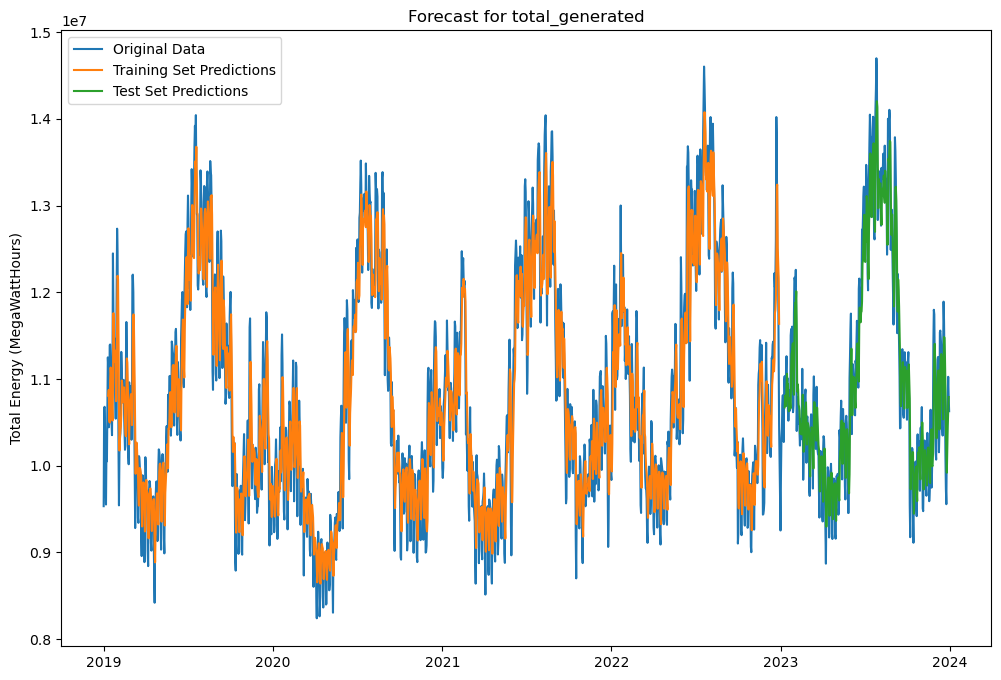

In [16]:
# Fit model for 20 epochs and get predictions
train_pred, test_pred = get_predictions(model, X_train, y_train, epochs=20)

# Revert scaling for target and predictions
y_train_unscaled, train_pred_unscaled = unscale_data(scaler, y_train, train_pred)
y_test_unscaled, test_pred_unscaled = unscale_data(scaler, y_test, test_pred)

# Get rmse for both sets of data
rmse_train = root_mean_squared_error(y_train_unscaled, train_pred_unscaled)
rmse_test = root_mean_squared_error(y_test_unscaled, test_pred_unscaled)

# Align prediction data to match original data x-axis
shifted_train_pred, shifted_test_pred = shift_predictions(train_pred_unscaled,
                                                          test_pred_unscaled,
                                                          total_generated_df,
                                                          window_size=10)

print(f'''
    RMSE on Train Set: {rmse_train:.3f}
    RMSE on Test Set: {rmse_test:.3f}
    ''')

# Plot predictions against original data
plot_predictions(total_generated_df, shifted_train_pred, shifted_test_pred)

## Optimizing LSTM Model
Test the following:
* Vary number of nodes in layers
* Vary number of layers
* Vary training epochs
* Vary window size (note: will need to create new train/test sets)

### Vary number of nodes

In [17]:
# Build model
model = Sequential()
model.add(LSTM(128, input_shape=(10, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


12/12 [==============================] - 0s 3ms/step

    RMSE on Train Set: 394354.535
    RMSE on Test Set: 367109.433
    


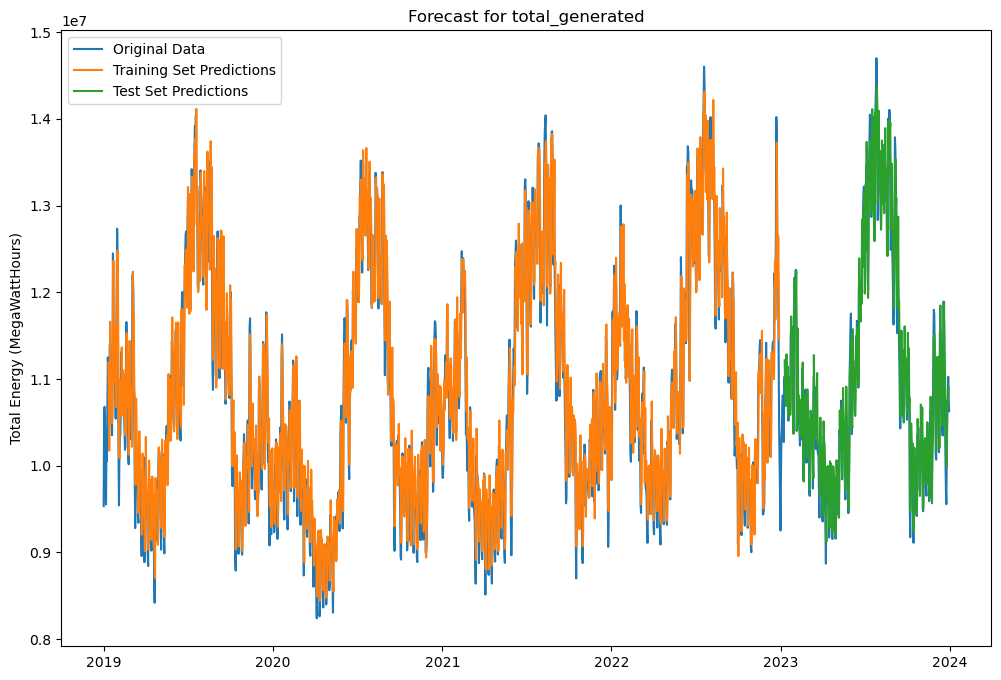

In [18]:
# Fit model for 20 epochs and get predictions
train_pred, test_pred = get_predictions(model, X_train, y_train, epochs=20)

# Revert scaling for target and predictions
y_train_unscaled, train_pred_unscaled = unscale_data(scaler, y_train, train_pred)
y_test_unscaled, test_pred_unscaled = unscale_data(scaler, y_test, test_pred)

# Get rmse for both sets of data
rmse_train = root_mean_squared_error(y_train_unscaled, train_pred_unscaled)
rmse_test = root_mean_squared_error(y_test_unscaled, test_pred_unscaled)

# Align prediction data to match original data x-axis
shifted_train_pred, shifted_test_pred = shift_predictions(train_pred_unscaled,
                                                          test_pred_unscaled,
                                                          total_generated_df,
                                                          window_size=10)

print(f'''
    RMSE on Train Set: {rmse_train:.3f}
    RMSE on Test Set: {rmse_test:.3f}
    ''')

# Plot predictions against original data
plot_predictions(total_generated_df, shifted_train_pred, shifted_test_pred)

### Adjust amount of layers

Note: if messing with multiple LSTM layers, consider dropout layer; more layers may not be the best approach regardless due to possible overfitting.

In [19]:
# Build model
model = Sequential()
model.add(LSTM(128, input_shape=(10, 1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 118,593
Trainable params: 118,593
Non-trainable params: 0
_________________________________________________________________


12/12 [==============================] - 0s 4ms/step

    RMSE on Train Set: 432369.431
    RMSE on Test Set: 407555.606
    


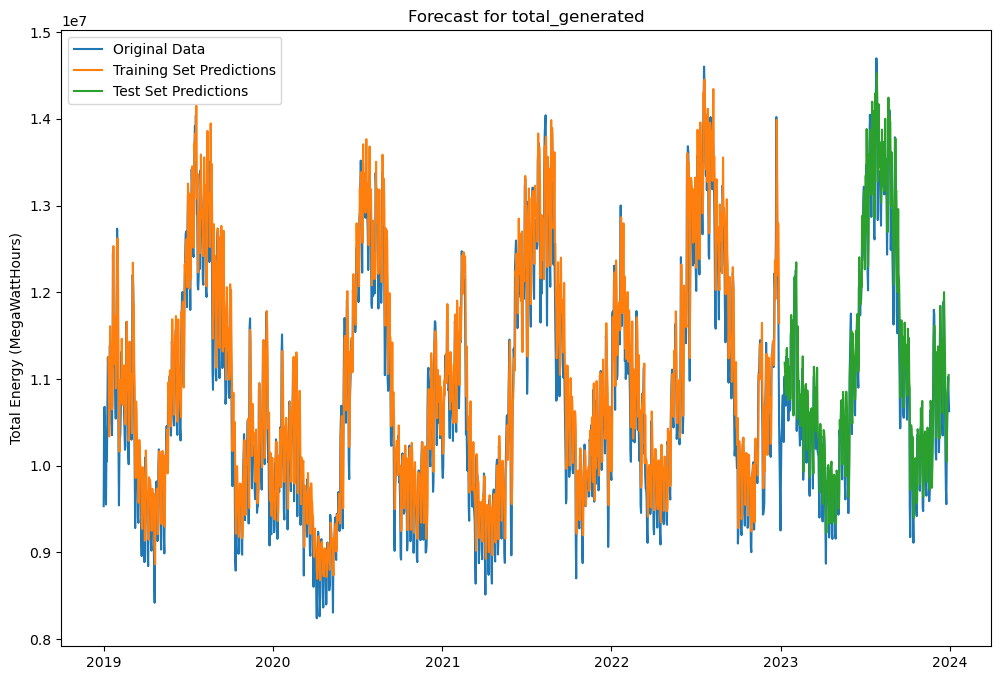

In [20]:
# Fit model for 20 epochs and get predictions
train_pred, test_pred = get_predictions(model, X_train, y_train, epochs=20)

# Revert scaling for target and predictions
y_train_unscaled, train_pred_unscaled = unscale_data(scaler, y_train, train_pred)
y_test_unscaled, test_pred_unscaled = unscale_data(scaler, y_test, test_pred)

# Get rmse for both sets of data
rmse_train = root_mean_squared_error(y_train_unscaled, train_pred_unscaled)
rmse_test = root_mean_squared_error(y_test_unscaled, test_pred_unscaled)

# Align prediction data to match original data x-axis
shifted_train_pred, shifted_test_pred = shift_predictions(train_pred_unscaled,
                                                          test_pred_unscaled,
                                                          total_generated_df,
                                                          window_size=10)

print(f'''
    RMSE on Train Set: {rmse_train:.3f}
    RMSE on Test Set: {rmse_test:.3f}
    ''')

# Plot predictions against original data
plot_predictions(total_generated_df, shifted_train_pred, shifted_test_pred)

### Vary training epochs

In [21]:
# Build model
model = Sequential()
model.add(LSTM(128, input_shape=(10, 1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 128)           66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 118,593
Trainable params: 118,593
Non-trainable params: 0
_________________________________________________________________


12/12 [==============================] - 0s 4ms/step

    RMSE on Train Set: 359023.785
    RMSE on Test Set: 335421.844
    


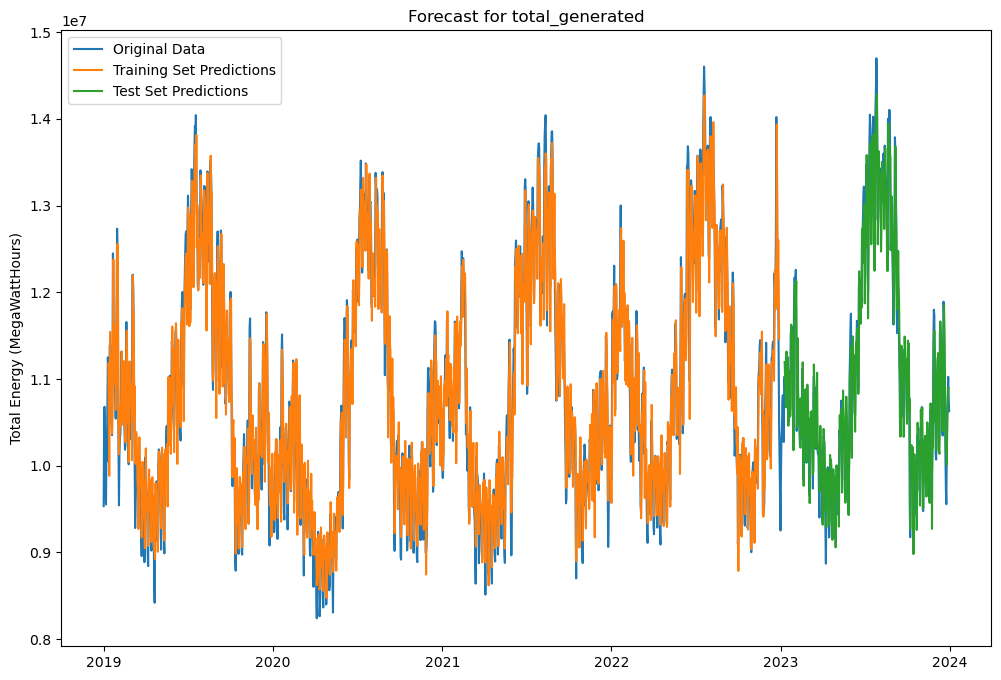

In [22]:
# Fit model for 50 epochs and get predictions
train_pred, test_pred = get_predictions(model, X_train, y_train, epochs=50)

# Revert scaling for target and predictions
y_train_unscaled, train_pred_unscaled = unscale_data(scaler, y_train, train_pred)
y_test_unscaled, test_pred_unscaled = unscale_data(scaler, y_test, test_pred)

# Get rmse for both sets of data
rmse_train = root_mean_squared_error(y_train_unscaled, train_pred_unscaled)
rmse_test = root_mean_squared_error(y_test_unscaled, test_pred_unscaled)

# Align prediction data to match original data x-axis
shifted_train_pred, shifted_test_pred = shift_predictions(train_pred_unscaled,
                                                          test_pred_unscaled,
                                                          total_generated_df,
                                                          window_size=10)

print(f'''
    RMSE on Train Set: {rmse_train:.3f}
    RMSE on Test Set: {rmse_test:.3f}
    ''')

# Plot predictions against original data
plot_predictions(total_generated_df, shifted_train_pred, shifted_test_pred)